<a href="https://colab.research.google.com/github/USCbiostats/PM520/blob/main/Lab_8_Variational_Inference_PtI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running Up That Hill, or: Intro to Variational (Bayesian) Inference
$\newcommand{\data}{\text{Data}}$
$\newcommand{\E}{\mathbb{E}}$
Recall that in Bayesian inference, we seek to model the uncertainty in our estimates through a _posterior_ distribution. The posterior is derived from [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) as,
$$\Pr(\theta | \data) = \frac{\Pr(\data | \theta) \Pr(\theta)}{\Pr(\data)},$$
where $\Pr(\theta | \data)$ is the [_posterior_ probability](https://en.wikipedia.org/wiki/Posterior_probability) for $\theta$ and reflects our uncertainty in the values that $\theta$ may take on, $\Pr(\data | \theta)$ is our likelihood, $\Pr(\theta)$ is a [_prior_ probability](https://en.wikipedia.org/wiki/Prior_probability) (or _prior_) over $\theta$ and $\Pr(\data)$ is a [_marginal_ probability/likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood) of the data.

Last week, we explored this concept in the regime of "brute forcing" the posterior distribution for a simple exercise (e.g., calculating posterior probability an individual is sick, given a positive test) as well as a result in [Exponential Families](https://en.wikipedia.org/wiki/Exponential_family) that leveraged [conjugacy](https://en.wikipedia.org/wiki/Conjugate_prior) (e.g., posterior probability for a coin to land on "heads").

> *What happens if our model does not have a simple to evaluate or conjugate posterior?*

Historically, this is where [Monte-Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method) typically apply, however, these approaches are limited to low- to medium-dimensional applications in practice, and unlikely to scale to ultra high-dimensional settings common in modern datasets (e.g., genetics, genomics, etc).

## Exact Approximate Inference 🤔

Rather than performing inference under an intractible exact posterior $\Pr(\theta | \data)$, we seek to perform inference using a surrogate distribution $Q(\theta | \data)$ that is simpler. But how to identify or even quantify how good a proposed surrogate distribution $Q$ is?

Recall, [KL-Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) captures a notion of "[statistical distance](https://en.wikipedia.org/wiki/Statistical_distance)" between parameterized distribution functions, whose definition for discrete variables is,
$$
\begin{align*}
D_{KL}(q || p) &= \sum_{x \in \mathcal{X}} q(x) \log \frac{q(x)}{p(x)} = - \sum_{x \in \mathcal{X}} q(x) \log \frac{p(x)}{q(x)}
  = -\mathbb{E}_{x \sim q}\left[\log \frac{p(x)}{q(x)} \right].
\end{align*}$$

For continuous $x \in \mathbb{R}$, we have,
$$\begin{align*}
D_{KL}(q || p) &= \int_{-\infty}^\infty q(x) \log \frac{q(x)}{p(x)}dx = -\int_{-\infty}^\infty q(x) \log \frac{p(x)}{q(x)}dx
  = -\mathbb{E}_{x \sim q}\left[\log \frac{p(x)}{q(x)} \right].
\end{align*}$$

We can leverage this concept to measure how good a proposal surrogate $Q$ is compared to the true posterior by,
$$D_{KL}(Q(\theta | \data) || \Pr(\theta | \data))$$
however, we often don't know the functional form of $\Pr(\theta | \data)$ let alone compute it in intracable settings! Where are we left?

$$\newcommand{\ELBO}{\text{ELBO}}\begin{align*}
D_{KL}(Q(\theta | \data) || \Pr(\theta | \data)) &= \E_Q\left[ \log \frac{Q(\theta | \data)}{\Pr(\theta | \data) }\right] \\
  &= \E_Q\left[ \log \frac{Q(\theta | \data)\Pr(\data)}{\Pr(\data | \theta) \Pr(\theta)}\right] \\
  &= \E_Q\left[ \log \frac{Q(\theta | \data)}{\Pr(\data | \theta) \Pr(\theta)}\right] + \E_Q[\log \Pr(\data) ]\\
  &= \E_Q\left[ \log \frac{Q(\theta | \data)}{\Pr(\data | \theta) \Pr(\theta)}\right] + \log \Pr(\data) \\
  &= \underbrace{\E_Q[ \log Q(\theta | \data)] - \E_Q[\log \Pr(\data | \theta)] - \E_Q[\log \Pr(\theta)]}_{-\ELBO} + \log \Pr(\data) \geq 0 ⇒\\
-\ELBO \geq - \log \Pr(\data) \iff \ELBO \leq \log \Pr(\data).
\end{align*}$$

The implications of the above derivation suggest that we can maximize the [*evidence lower bound*](https://en.wikipedia.org/wiki/Evidence_lower_bound) or $\ELBO$ to minimize the KL-divergence between $Q$ and $\Pr(\theta | \data)$ up to a constant.

Given this, a helpful representation of the $\ELBO$ is to re-write it as,
$$\begin{align*}
\ELBO &:= -\E_Q[ \log Q(\theta | \data)] + \E_Q[\log \Pr(\data | \theta)] + \E_Q[\log \Pr(\theta)] \\
  &= \E_Q[\log \Pr(\data | \theta)] - \E_Q\left[ \log \frac{Q(\theta | \data)}{\Pr(\theta)}\right]\\
  &= \E_Q[\log \Pr(\data | \theta)] + D_{KL}(Q(\theta | \data) || \Pr(\theta)).
\end{align*}$$

Fantastic! We've specified how to evaluate our objective (i.e. $\ELBO$), but we haven't yet specified how to maximize it. As currently stated, we are left with a bit of a puzzle.

> *How do we proceed given that $Q$ is a _function_ to identify, and not some fixed variable/parameter?*

## Variational Inference
$\newcommand{\indep}{\perp \!\!\!\! \perp}$
Before we attempt to maximize the $\ELBO$, we need to specify the *structural* form of $Q$. Namely, how does $Q$ factorize with respect to our model variables? Typically a *mean-field* factorization is used, which implies that
$$Q(\theta) = \prod_{j=1}^p Q_j(\theta_j),$$ or, intuitively that each $\theta_j \indep \theta_{j'}$ for $j \neq j'$ under $Q$. There are certainly other options for how to factor $Q$ over latent variables (e.g., *structured* mean-field, etc), and trade-offs can sometimes be made over model/computational complexity and downstream accuracy, but often the simplest place to begin is the mean field.

Given a factorization for $Q$, we seek to identify the optimal $Q_j^*$ by leveraging optimization techniques from the [calculus of variations](https://en.wikipedia.org/wiki/Calculus_of_variations) (namely the [Euler-Lagrance](https://en.wikipedia.org/wiki/Euler%E2%80%93Lagrange_equation) equation), which tells us that,
$$\begin{align*}
\log Q_j^*(\theta_j) &= \E_Q\left[\log \Pr(\data | \theta) | \theta_j\right] + \E_Q\left[\log \Pr(\theta) | \theta_j \right].
\end{align*}$$
Here, we condition on $\theta_j$, and compute expectations with respect to $Q$ for _other_ variables $\theta_{j'}$. Usually, our goal will be to push through some tedious algebra and identify a familiar parametric form that describes $Q_j^*$. However, to do this, we'll need to be able to compute expectations of _other_ approximate posteriors $Q_{j'}^*$, which suggests a cyclic algorithm. In other words, We perform updates for one variable at a time (i.e. [coordinate ascent](https://en.wikipedia.org/wiki/Coordinate_descent) variational inference), or CAVI for short.


Together the CAVI algorithm looks like,

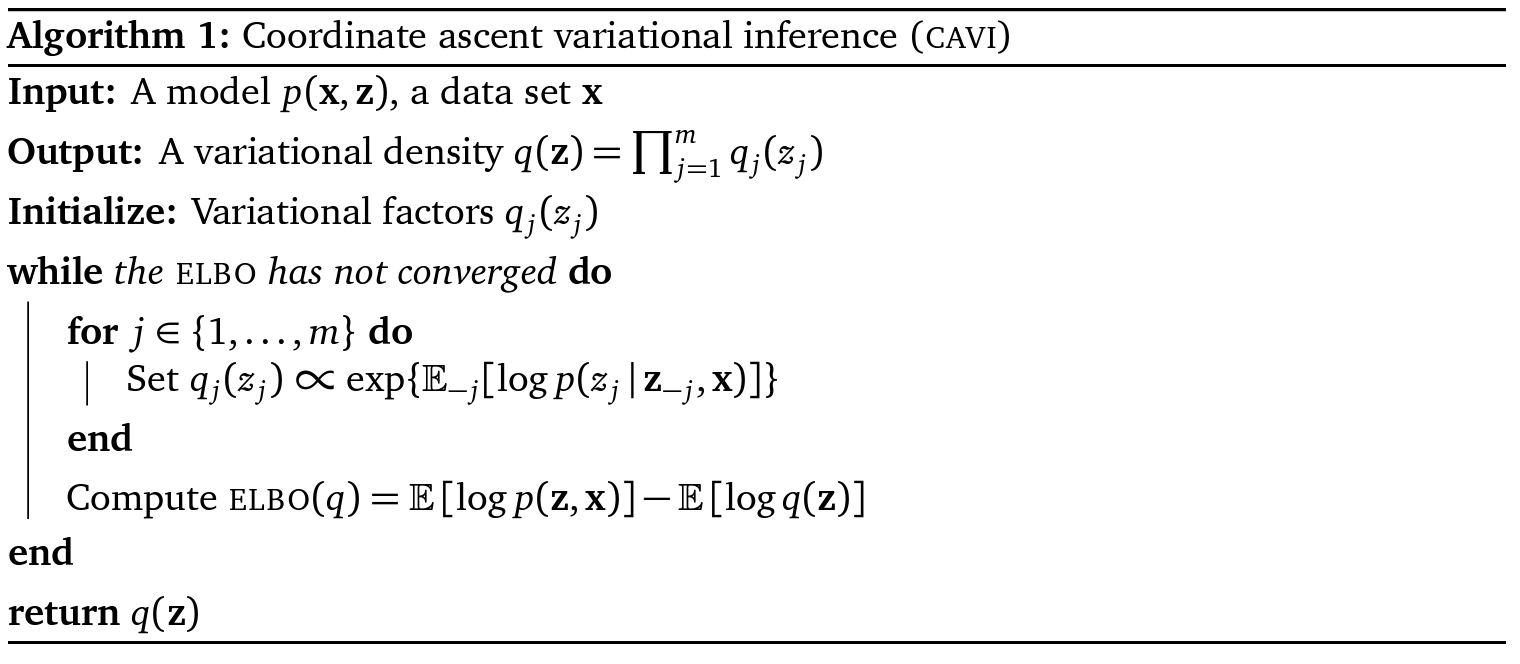


It is worth noting how different this paradigm is compared to conjugate- or sampling-based Bayesian inference. Here we are performing _optimization_ to identify parametric forms for our surrogate distributions $Q_j$, as opposed to evaluating integrals directly! Hence, we are performing _exact_ optimization for a distribution that _approximates_ the true posterior.

## Example: Bayesian Linear Regression
$\newcommand{\bX}{\mathbf{X}}\newcommand{\by}{\mathbf{y}}\newcommand{\bI}{\mathbf{I}}$
Let's say we observe $y_i, x_i$ pairs where
$$\begin{align*}
y_i | x_i, \beta &\sim N(x_i^T \beta, \sigma^2) \\
\beta_j &\sim N(0, \sigma^2_b).
\end{align*}$$

If we observe $n$ pairs of $\{y_i, x_i\}$, we can re-write the above as
$$\begin{align*}
\by | \bX, \beta &\sim N(\bX\beta, \bI_n \sigma^2) \\
\beta &\sim N(0, \bI_p \sigma^2_b).
\end{align*}$$

Here, we'd like to identify an approximate posterior $Q(\beta)$, rather than its exact posterior $\Pr(\beta | \by)$. Let's take a mean-field approach and assume that $Q$ factorizes as $$Q(\beta) = \prod_{j=1}^P Q_j(\beta_j).$$

Next, we need to identify the optimal $Q_j^*$ for each $j$. Namely,
$$\begin{align*}
\log Q_j^*(\beta_j) &= \E_Q\left[\log \Pr(\by | \beta) | \beta_j\right] + \E_Q\left[\log \Pr(\beta) | \beta_j \right] \\
  &= \E_Q\left[\log N(\by | \bX \beta, \bI_n \sigma^2) | \beta_j\right]
  + \E_Q\left[\log N(\beta | 0, \bI_p \sigma^2_b) | \beta_j \right] \\
  &= \E_Q\left[\log N(\by | \bX \beta, \bI_n \sigma^2) | \beta_j\right]
  + \E_Q\left[-\frac{1}{2 \sigma^2_b}\sum_{j'=1}^P \beta_{j'}^2 \ | \ \beta_j \right] \\
  &= \E_Q\left[\log N(\by | \bX \beta, \bI_n \sigma^2) | \beta_j\right]
  + \E_Q\left[-\frac{1}{2 \sigma^2_b} \beta_j^2 \ | \ \beta_j \right] \\
  &= \E_Q\left[\log N(\by | \bX \beta, \bI_n \sigma^2) | \beta_j\right]
  -\frac{\beta_j^2}{2 \sigma^2_b} + O(1) \\
  &= \E_Q\left[-\frac{1}{2 \sigma^2}(\by - \bX \beta)^T(\by - \bX \beta) \ | \ \beta_j\right]
  -\frac{\beta_j^2}{2 \sigma^2_b} + O(1) \\
\end{align*}$$
$\newcommand{\resid}{\mathbf{r}}$
To proceed, let's first define a residual $\resid_j := \by - \sum_{j' \neq j} \bX_{j'}\beta_{j'}$ that reflects residualizing $\by$ by everything _except_ the $j$th term. Continuing we have,
$$\begin{align*}
\log Q_j^*(\beta_j) &=
  \E_Q\left[-\frac{1}{2 \sigma^2}(\by - \bX \beta)^T(\by - \bX \beta) \ | \ \beta_j\right]
  -\frac{\beta_j^2}{2 \sigma^2_b} + O(1) \\
  &= \E_Q\left[-\frac{1}{2 \sigma^2}(\resid_j - \bX_j \beta_j)^T(\resid_j - \bX_j \beta_j) \ | \ \beta_j\right]
  -\frac{\beta_j^2}{2 \sigma^2_b} + O(1) \\
  &= -\frac{1}{2 \sigma^2}\E_Q\left[\resid_j^T\resid_j - 2\resid_j^T\bX_j \beta_j + \beta_j^2 X_j^T X_j \ | \ \beta_j\right]
  -\frac{\beta_j^2}{2 \sigma^2_b} + O(1) \\
  &= -\frac{1}{2 \sigma^2}\E_Q\left[ - 2\resid_j^T\bX_j \beta_j + \beta_j^2 X_j^T X_j \ | \ \beta_j\right]
  -\frac{\beta_j^2}{2 \sigma^2_b} + O(1) \\
  &= \frac{1}{\sigma^2}\E_Q[\resid_j^T]\bX_j \beta_j -\frac{1}{2\sigma^2}\beta_j^2 X_j^T X_j
  -\frac{\beta_j^2}{2 \sigma^2_b} + O(1) \\
  &= \frac{1}{\sigma^2}\E_Q[\resid_j^T]\bX_j\beta_j -\frac{1}{2}\beta_j^2 \underbrace{\left(\frac{X_j^T X_j}{\sigma^2}
  + \frac{1}{\sigma^2_b}\right)}_{1 / \widetilde{\sigma}^2_j} + O(1) \\
  &= \frac{1}{\widetilde{\sigma}^2_j}\underbrace{\frac{\widetilde{\sigma}^2_j}{\sigma^2}\E_Q[\resid_j^T]\bX_j}_{\tilde{\mu}_j}\beta_j -\frac{\beta_j^2}{2\widetilde{\sigma}^2_j} + O(1) \\
  &= \frac{\tilde{\mu}_j\beta_j}{\widetilde{\sigma}^2_j} -\frac{\beta_j^2}{2\widetilde{\sigma}^2_j}
  - \frac{\tilde{\mu}_j^2}{2\widetilde{\sigma}^2_j} + O(1) \\
  &= \frac{(\beta_j - \tilde{\mu}_j)^2}{2 \widetilde{\sigma}^2_j} + O(1) \Rightarrow\\
Q_j^*(\beta_j) &= N(\beta_j | \tilde{\mu}_j, \widetilde{\sigma}^2_j).
\end{align*}$$
This implies that the _optimal_ $Q_j^*(\beta_j)$ is a normal distribution with variational parameters $\tilde{\mu}_j, \widetilde{\sigma}^2_j$. Together we have,
$$Q(\beta) = \prod_j Q_j(\beta_j) = \prod_j N(\beta_j | \tilde{\mu}_j, \widetilde{\sigma}^2_j).$$

Comparing this to the _true_ posterior (which is tractable in this case) we have,
$$\begin{align*}
\Pr(\beta | \by) &= N(\beta | \widetilde{\beta}, \widetilde{\Sigma}) \\
\widetilde{\beta} &= \frac{1}{\sigma^2}\widetilde{\Sigma}\bX^T\by \\
\widetilde{\Sigma} &= (\bX^T\bX\frac{1}{\sigma^2} + \bI_p \frac{1}{\sigma^2_b})^{-1}\\
\end{align*}$$


In [ ]:
# Let's code up the CAVI algorithm for bayesian linear regression

import jax
import jax.numpy as jnp
import jax.random as rdm

MAX_ITER = 10

N = 500
P = 250
sigma_sq = 0.8
sigma_sq_b = 0.1

seed = 0
key = rdm.PRNGKey(seed)
key, x_key, b_key, y_key = rdm.split(key, 4)

X = rdm.normal(x_key, shape=(N, P))
beta = jnp.sqrt(sigma_sq_b) * rdm.normal(b_key, shape=(P,))
y = X @ beta + jnp.sqrt(sigma_sq) * rdm.normal(y_key, shape=(N,))

post_means = jnp.zeros((P,))
post_vars = jnp.ones((P,)) * sigma_sq_b

#NB: in jax to update an array position j, we need the `set` function which
# looks like post_means = post_means.at[j].set(new_value)
for _iter in range(MAX_ITER):
  resid = y - X @ post_means
  for j in range(P):
    Xj = X[:,j]
    resid_j = resid + Xj * post_means[j]

    # update post_vars[j]
    post_prec_j = jnp.sum(Xj**2) / sigma_sq + 1. / sigma_sq_b
    post_vars = post_vars.at[j].set(1. / post_prec_j)

    # update post_means[j]
    mu_j = (resid_j @ Xj) * post_vars[j] / sigma_sq
    post_means = post_means.at[j].set(mu_j)
    resid = resid_j - Xj * post_means[j]

  # typically we would evaluate the ELBO here, but that is left as HW exercise...
  mse = jnp.mean((beta - post_means)**2 / post_vars)
  print(f"MSE @ ITER[{_iter}] = {mse}")

MSE @ ITER[0] = 21.340829849243164
MSE @ ITER[1] = 8.019566535949707
MSE @ ITER[2] = 4.630098342895508
MSE @ ITER[3] = 3.258354425430298
MSE @ ITER[4] = 2.605468988418579
MSE @ ITER[5] = 2.2769148349761963
MSE @ ITER[6] = 2.105119466781616
MSE @ ITER[7] = 2.01315975189209
MSE @ ITER[8] = 1.9631763696670532
MSE @ ITER[9] = 1.9356772899627686
